In [4]:
# Environment: syn_gen
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pymatgen import Composition, Element
import pickle as pkl
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

In [5]:
with open('/home/jupyter/CJK/TempTime/data/ss_extracted_NO_IMPUTATION_precs_all_targets.pkl', 'rb') as f:
    papers = pkl.load(f)

In [6]:
# only use papers with sinter temps
papers = [x for x in papers if not np.isnan(x['temp_time_vector'][1])]

In [7]:
test_targets = [x['target'] for x in papers]
test_precs = [x['precursors'] for x in papers]
test_temps = [x['temp_time_vector'][1] for x in papers]

In [8]:
# get means
test_results = []
for target, precs, temps in zip(test_targets, test_precs, test_temps):
    if len(test_precs) == 0:
        continue
    found = False
    for result in test_results:
        if result["Target"] == target: # and set(result["Precursors"]) == set(precs):
            result["ss_sinter_temps"].append(temps)
            result["Precursors"].append(precs)
            found = True
    if not found:
        new_result = {}
        new_result["Target"] = target
        new_result["Precursors"] = [precs]
        new_result["ss_sinter_temps"] = []
        new_result["ss_sinter_temps"].append(temps)
        test_results.append(new_result)

In [9]:
target_names = [x["Target"] for x in test_results]
precursors = [x["Precursors"] for x in test_results]
temps = [np.mean(x["ss_sinter_temps"]) for x in test_results]
num_pts = [len(x["ss_sinter_temps"]) for x in test_results]

In [10]:
feature_calculators = MultipleFeaturizer([
    cf.Stoichiometry(),
    cf.ElementProperty.from_preset("magpie"),
    cf.ValenceOrbital(props=["avg"]),
    cf.IonProperty(fast=True)
])

In [11]:
feature_labels = feature_calculators.feature_labels()

In [12]:
data = pd.DataFrame()
data["targets"] = target_names
data["precursors"] = precursors
data["temperatures"] = temps
df = StrToComposition(target_col_id="composition_obj").featurize_dataframe(data, "targets", ignore_errors=True)
df = feature_calculators.featurize_dataframe(df, col_id="composition_obj", ignore_errors = True)

In [24]:
df

,targets,precursors,temperatures,composition_obj,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,...,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char
0,Sr0.5Nd0.5CoO3,"[[SrCO3, Nd2O3, Co3O4]]",1200.000000,"(Sr, Nd, Co, O)",4,0.648074,0.609120,0.600524,0.600040,0.600001,...,87.900000,91.080000,12.0,2.000000,2.400000,1.400000,0.400000,False,0.787757,0.152508
1,NdCoO3,"[[Nd2O3, Co3O4], [Co2O3, Nd2O3], [Co2O3, Nd2O3]]",1200.000000,"(Nd, Co, O)",3,0.663325,0.614463,0.600984,0.600078,0.600002,...,84.800000,87.360000,12.0,2.000000,2.400000,1.400000,0.800000,True,0.733532,0.147835
2,Sr0.4Pr0.6CoO3,"[[SrCO3, Pr6O11, Co2O3], [SrCO3, Pr6O11, Co3O4...",1250.000000,"(Sr, Pr, Co, O)",4,0.648691,0.609335,0.600536,0.600040,0.600001,...,87.280000,90.336000,12.0,2.000000,2.400000,1.400000,0.360000,False,0.787757,0.151877
3,Sr0.4Gd0.6CoO3,"[[SrCO3, Co2O3, Gd2O3], [SrCO3, Gd2O3, Co3O4],...",1283.333333,"(Sr, Gd, Co, O)",4,0.648691,0.609335,0.600536,0.600040,0.600001,...,87.280000,90.336000,12.0,2.000000,2.400000,1.520000,0.840000,False,0.787757,0.149848
4,Li1.3Mn0.65Ni0.35O2.3,"[[MnO2, LiOH, Ni(NO3)2], [MnO2, LiOH, Ni(NO3)2]]",800.000000,"(Li, Mn, Ni, O)",4,0.596342,0.532311,0.505820,0.501316,0.500166,...,118.500000,106.500000,12.0,1.717391,2.000000,1.315217,0.000000,True,0.779730,0.176399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11689,Sm0.55Ce0.45O2,"[[CeO2, Sm2O3]]",1690.000000,"(Sm, Ce, O)",3,0.707500,0.673744,0.666953,0.666681,0.666667,...,67.533333,74.044444,12.0,2.000000,2.666667,0.150000,1.250000,False,0.739617,0.162497
11690,Sm0.05Ce0.95O2,"[[CeO2, Sm2O3]]",1690.000000,"(Sm, Ce, O)",3,0.738241,0.689682,0.669860,0.667185,0.666706,...,72.200000,80.266667,12.0,2.000000,2.666667,0.316667,0.416667,False,0.739617,0.164192
11691,ZrTa2ZnO8,"[[Ta2O5, ZnO, ZrO2]]",1360.000000,"(Zr, Ta, Zn, O)",4,0.697217,0.670979,0.666805,0.666673,0.666667,...,78.500000,88.666667,12.0,2.000000,2.666667,1.500000,2.333333,True,0.671436,0.136021
11692,La2Y0.32Zr1.68O6.84,"[[ZrO2, La2O3, Y2O3]]",1650.000000,"(La, Y, Zr, O)",4,0.676083,0.639283,0.631378,0.631018,0.630997,...,79.158672,84.753748,12.0,2.000000,2.523985,0.523985,0.000000,True,0.745613,0.166069


In [28]:
# omit_columns = ['targets', 'precursors', 'temperatures', 'composition_obj']
# X_columns = list(set(list(df.columns)) - set(omit_columns))
# y_column = 'temperatures'
# X_df = df[X_columns]
# X_columns = list(X_df.columns)
# X = X_df.values

X = df.drop(['targets', 'precursors', 'temperatures', 'composition_obj'], axis = 1)
y = df['temperatures'].values
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (11694, 145)
Shape of y: (11694,)


In [31]:
list(X.columns)

['0-norm',
 '2-norm',
 '3-norm',
 '5-norm',
 '7-norm',
 '10-norm',
 'MagpieData minimum Number',
 'MagpieData maximum Number',
 'MagpieData range Number',
 'MagpieData mean Number',
 'MagpieData avg_dev Number',
 'MagpieData mode Number',
 'MagpieData minimum MendeleevNumber',
 'MagpieData maximum MendeleevNumber',
 'MagpieData range MendeleevNumber',
 'MagpieData mean MendeleevNumber',
 'MagpieData avg_dev MendeleevNumber',
 'MagpieData mode MendeleevNumber',
 'MagpieData minimum AtomicWeight',
 'MagpieData maximum AtomicWeight',
 'MagpieData range AtomicWeight',
 'MagpieData mean AtomicWeight',
 'MagpieData avg_dev AtomicWeight',
 'MagpieData mode AtomicWeight',
 'MagpieData minimum MeltingT',
 'MagpieData maximum MeltingT',
 'MagpieData range MeltingT',
 'MagpieData mean MeltingT',
 'MagpieData avg_dev MeltingT',
 'MagpieData mode MeltingT',
 'MagpieData minimum Column',
 'MagpieData maximum Column',
 'MagpieData range Column',
 'MagpieData mean Column',
 'MagpieData avg_dev Column'

In [16]:
X_train, X_test, y_train, y_test, num_pts_train, num_pts_test = train_test_split(X, y, num_pts, test_size=0.10, shuffle=True)

regr = RandomForestRegressor()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
y_pred_train = regr.predict(X_train)

train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
regr_importances = regr.feature_importances_

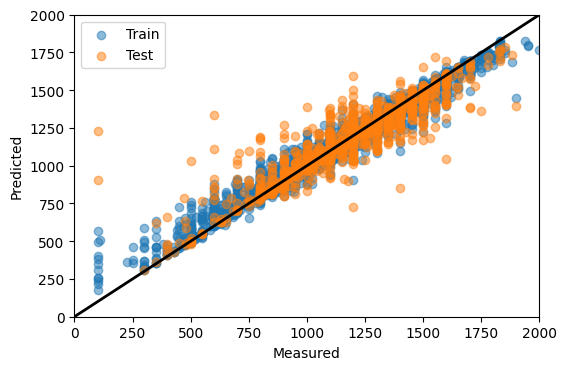

In [ ]:
fig, ax = plt.subplots(dpi=100)
ax.scatter(y_train, y_pred_train, alpha=0.5, label="Train")
ax.scatter(y_test, y_pred, alpha=0.5, label="Test")
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.legend()
ax.plot([0, 2000], [0, 2000], "k-", lw=2)
ax.set_xlim([0, 2000])
ax.set_ylim([0, 2000])
plt.show()

In [17]:
print("Fit Statistics:")

print("Training Score: {}".format(regr.score(X_train, y_train)))
print("Training MAE: {}".format(train_mae))
print("Training RMSE: {}".format(train_rmse))
print("Testing Score: {}".format(regr.score(X_test, y_test)))
print("Testing MAE: {}".format(test_mae))
print("Testing RMSE: {}".format(test_rmse))

Fit Statistics:
Training Score: 0.975686611163232
Training MAE: 21.941119216289906
Training RMSE: 40.095536541424224
Testing Score: 0.8655308151705174
Testing MAE: 51.04005172038611
Testing RMSE: 93.4310449037648


In [2]:
# # Save model
# joblib.dump(regr, "rf_sinter_predict_no_imputation_no_precursors.joblib")

# load model
regr = joblib.load("rf_sinter_predict_no_imputation_no_precursors.joblib")
regr

RandomForestRegressor()

In [16]:
inds = np.argsort(regr_importances)

In [17]:
for i in inds[::-1]:
    print(feature_labels[i], regr_importances[i])

MagpieData mean NValence 0.08375075985843626
MagpieData maximum NUnfilled 0.07987855713917122
MagpieData mode NpValence 0.06120170539876639
MagpieData minimum NValence 0.05572521708787155
MagpieData minimum GSmagmom 0.051027315975326316
MagpieData mode Number 0.04475005573787634
MagpieData avg_dev MeltingT 0.042214418626956796
MagpieData maximum Electronegativity 0.030793182360823998
MagpieData mean MendeleevNumber 0.020288999821370324
MagpieData range NdValence 0.017126348826284648
MagpieData mean GSmagmom 0.016999478291898584
MagpieData mean CovalentRadius 0.015947069954390394
MagpieData minimum CovalentRadius 0.01575160441181901
MagpieData avg_dev NValence 0.01544077810124128
MagpieData minimum Row 0.015376338435750923
MagpieData minimum NsValence 0.012838736289966355
MagpieData mean NUnfilled 0.012594136182488891
MagpieData range NsValence 0.012539859858259077
MagpieData mode NpUnfilled 0.012081476435997902
MagpieData mean NpUnfilled 0.010836029799398636
MagpieData mode NsUnfilled 

# Check error as function of num. points

In [18]:
all_maes = []
all_rmses = []
all_r2 = []
min_num_pts = [i for i in range(1, 6)]
for i in min_num_pts:
    X_test_subset = []
    y_test_subset = []
    for ind in range(len(num_pts_test)):
        if num_pts_test[ind] >= i:
            X_test_subset.append(X_test[ind])
            y_test_subset.append(y_test[ind])
    y_pred_subset = regr.predict(X_test_subset)
    all_maes.append(mean_absolute_error(y_test_subset, y_pred_subset))
    all_rmses.append(mean_squared_error(y_test_subset, y_pred_subset, squared=False))
    all_r2.append(r2_score(y_test_subset, y_pred_subset))
    

In [19]:
pd.Series(num_pts_test).value_counts()

1     950
2     141
3      30
4      18
6       9
5       7
7       4
12      2
8       2
28      1
18      1
16      1
15      1
11      1
10      1
9       1
dtype: int64

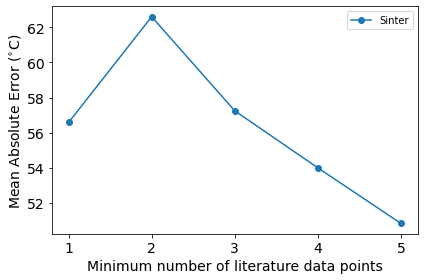

In [20]:
fig, ax = plt.subplots()
# plt.plot(num_pts, maes_2, marker='o')
plt.plot(min_num_pts, all_maes, marker='o')
ax.set_xlabel("Minimum number of literature data points", fontsize=14)
ax.set_ylabel("Mean Absolute Error ($^{\circ}$C)", fontsize=14)
ax.set_xticks(min_num_pts)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# ax.legend(["Calcine", "Sinter"])
ax.legend(["Sinter"])
fig.tight_layout()
# fig.savefig("/home/jupyter/CJK/CVAE/ceder_imputed/all_targets/neurips_paper/figures/ss_mae_num_examples.png", dpi=200)

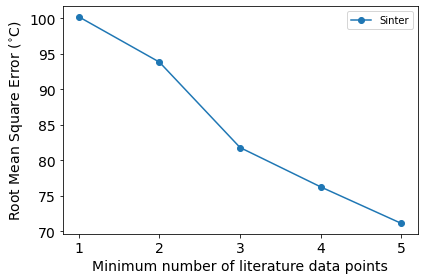

In [21]:
fig, ax = plt.subplots()
# plt.plot(num_pts, maes_2, marker='o')
plt.plot(min_num_pts, all_rmses, marker='o')
ax.set_xlabel("Minimum number of literature data points", fontsize=14)
ax.set_ylabel("Root Mean Square Error ($^{\circ}$C)", fontsize=14)
ax.set_xticks(min_num_pts)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# ax.legend(["Calcine", "Sinter"])
ax.legend(["Sinter"])
fig.tight_layout()
# fig.savefig("/home/jupyter/CJK/CVAE/ceder_imputed/all_targets/neurips_paper/figures/ss_mae_num_examples.png", dpi=200)

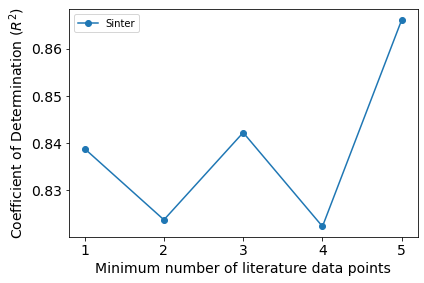

In [22]:
fig, ax = plt.subplots()
# plt.plot(num_pts, r2s_2, marker='o')
plt.plot(min_num_pts, all_r2, marker='o')
ax.set_xlabel("Minimum number of literature data points", fontsize=14)
ax.set_ylabel("Coefficient of Determination ($R^{2}$)", fontsize=14)
ax.set_xticks(min_num_pts)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# ax.legend(["Calcine", "Sinter"])
ax.legend(["Sinter"])
fig.tight_layout()
# fig.savefig("/home/jupyter/CJK/CVAE/ceder_imputed/all_targets/neurips_paper/figures/ss_r2_num_examples.png", dpi=200)

49


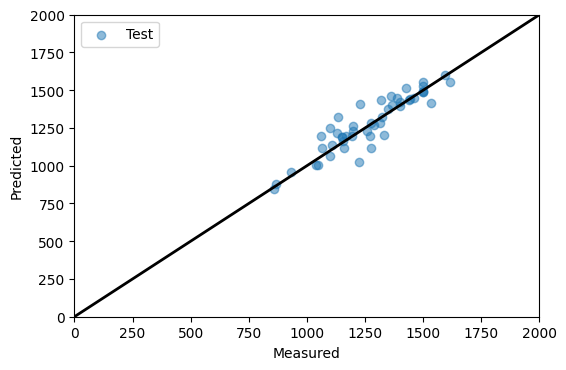

In [23]:
fig, ax = plt.subplots(dpi=100)
idx = [x for x in range(len(num_pts_test)) if num_pts_test[x] >= 4]
print(len(idx))
to_plot_test, to_plot_pred = [], []
for i in idx:
    to_plot_test.append(y_test[i])
    to_plot_pred.append(y_pred[i])
ax.scatter(to_plot_test, to_plot_pred, alpha=0.5, label="Test")
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.legend()
ax.plot([0, 2000], [0, 2000], "k-", lw=2)
ax.set_xlim([0, 2000])
ax.set_ylim([0, 2000])
plt.show()